In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools

import os, sys

project_root = '/user_data/mmhender/featsynth/'
# sys.path.append(os.path.join(project_root, 'code'))
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils
from behav_analysis import analyze_expt2

In [2]:
super_names, super_cbinds, basic_names, basic_inds, \
        super_names_long, super_inds_long, n_basic, n_super, n_basic_each_super = \
            analyze_expt2.get_categ_info()

trial_data_all, subjects, subject_cb, cue_level_names, image_type_names = analyze_expt2.load_data()
 
n_subjects = len(subjects)
n_cue_levels = len(cue_level_names)
n_image_types = len(image_type_names)

acc_by_condition, dprime_by_condition, propyes_by_condition, rt_by_condition = analyze_expt2.get_perf_by_cond()


#### Plotting params

In [3]:
cue_level_colors = np.array([[93,192,219], [44,92,168]])/255
point_types = ['o','x']
markersize = 4;
xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

#### d-prime values: two-way repeated measures anova, all subjects

In [4]:
vals = dprime_by_condition

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

print(aov_table)


All subjects:
(38, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond              61.383496     1.0    37.0  2.256978e-09
image_type       215.034485     4.0   148.0  1.399570e-60
cond:image_type    8.887297     4.0   148.0  1.850483e-06


#### t-tests comparing basic vs superordinate, within image type

In [14]:
tvals = np.zeros((5,))
pvals = np.zeros((5,))

df = pd.DataFrame(index=image_type_names)

vals = dprime_by_condition

print('All subjects:')
print(vals.shape)

for ii in range(n_image_types):

    p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])

    tvals[ii] = t
    pvals[ii] = p

df['t (basic-super)'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr
# df['p'] = pvals
        
df        
    

All subjects:
(38, 2, 5)


,t (basic-super),p
pool1,0.1893,0.850
pool2,-3.3981,0.005
pool3,-5.7327,0.000
pool4,-9.3265,0.000
orig,-4.2325,0.000


#### plot dprime, all subjects

Text(0.5, 1.0, 'All subjects (n=38)')

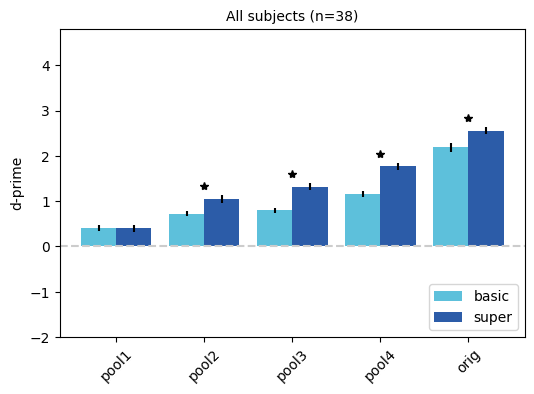

In [15]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = dprime_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    if pvals[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
        plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='lower right')

plt.ylabel('d-prime')

plt.ylim([-2, 4.8])

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### pairwise comparisons across image types

In [16]:
pairs_test = list(itertools.combinations(np.arange(5),2))
n_pairs = len(pairs_test)
pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]

tvals = np.zeros((n_pairs))
pvals = np.zeros((n_pairs))

df = pd.DataFrame(index=pair_names)

# averaging across basic/super conds here
vals = np.mean(dprime_by_condition, axis=1)

for pi, pair in enumerate(pairs_test):

    vals1 = vals[:,pair[0]]
    vals2 = vals[:,pair[1]]

    p, t = stats_utils.paired_ttest_nonpar(vals1, vals2)

    tvals[pi] = t
    pvals[pi] = p

df['t'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr

df   

,t,p
pool1 vs pool2,-7.9776,0.000
pool1 vs pool3,-8.7294,0.000
pool1 vs pool4,-12.7696,0.000
pool1 vs orig,-22.4857,0.000
pool2 vs pool3,-2.7933,0.008
pool2 vs pool4,-7.4367,0.000
pool2 vs orig,-20.3998,0.000
pool3 vs pool4,-6.2226,0.000
pool3 vs orig,-18.6878,0.000
pool4 vs orig,-17.0847,0.000


#### d-prime: separate out the two image sets

In [17]:
for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = dprime_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

    print(aov_table)


Image set 1:
(19, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond              23.947705     1.0    18.0  1.169359e-04
image_type       136.906958     4.0    72.0  7.300518e-33
cond:image_type    4.667564     4.0    72.0  2.090169e-03

Image set 2:
(19, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond             44.257803     1.0    18.0  3.045260e-06
image_type       84.379822     4.0    72.0  2.036177e-26
cond:image_type   5.350606     4.0    72.0  7.891809e-04


#### t-tests comparing basic vs superordinate, within image type

In [33]:
tvals = np.zeros((2,5))
pvals = np.zeros((2,5))

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = dprime_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    for ii in range(n_image_types):
        
        p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])
        
        tvals[cbi, ii] = t
        pvals[cbi, ii] = p
        
# fdr correcting all the values together
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cbi, cb in enumerate([1,2]):
    
    df['Set %d: t'%cb] = tvals[cbi,:].round(4)
    df['Set %d: p'%cb] = pvals_fdr[cbi,:]
    

df


Image set 1:
(19, 2, 5)

Image set 2:
(19, 2, 5)


,Set 1: t,Set 1: p,Set 2: t,Set 2: p
pool1,0.4054,0.735556,-0.0733,0.968
pool2,-0.6455,0.680000,-4.4880,0.000
pool3,-3.0442,0.013333,-5.8747,0.000
pool4,-7.4301,0.000000,-6.4073,0.000
orig,-2.6067,0.037143,-3.3429,0.000


#### plot d-prime for each image set

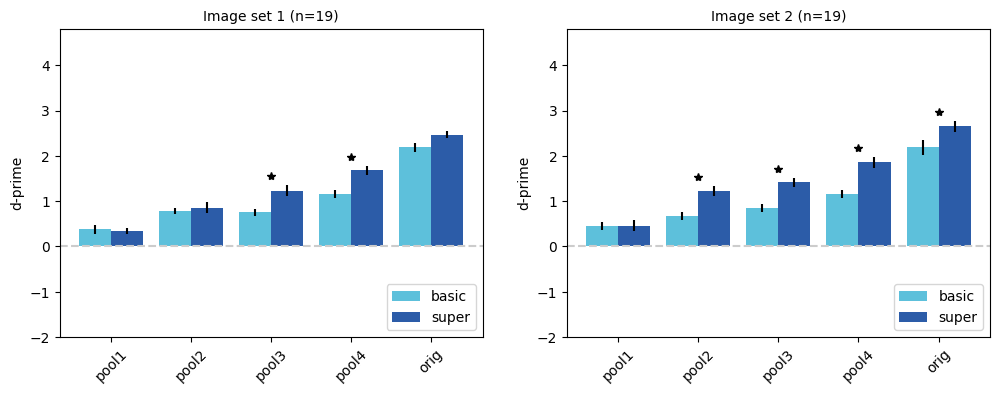

In [34]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(12,4))
    
for cbi, cb in enumerate([1,2]):

    ax = plt.subplot(1,2,cb)
    
    vals = dprime_by_condition[subject_cb==cbi,:,:]
    
    n_subs_plot = vals.shape[0]
        
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
    
    lh = []
    
    for ii in range(n_image_types):
        
        for cc, cue in enumerate(cue_level_names):
        
            h = plt.bar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                            color = cue_level_colors[cc,:], width=barwidth)
            
            plt.errorbar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                             semvals[cc,ii], \
                            color = 'k',
                            linestyle='none')
        
            lh.append(h)
    
        if pvals[cbi, ii]<0.01:
            height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
            plt.plot(ii, height, '*', color='k')
    
        
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)
    
        
        
    
    plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')
    
    ax.legend(lh, cue_level_names, loc='lower right')
    
    plt.ylabel('d-prime')
    
    plt.ylim([-2, 4.8])
    
    plt.title('Image set %d (n=%d)'%(cb, n_subs_plot))

#### Analyze RTs

In [35]:
vals = rt_by_condition

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

print(aov_table)


All subjects:
(38, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              2.761161     1.0    37.0  1.050293e-01
image_type       47.165243     4.0   148.0  1.641237e-25
cond:image_type   6.324499     4.0   148.0  1.001426e-04


#### compare basic vs superordinate, within image type

In [24]:
tvals = np.zeros((5,))
pvals = np.zeros((5,))

df = pd.DataFrame(index=image_type_names)

vals = rt_by_condition

print('All subjects:')
print(vals.shape)

for ii in range(n_image_types):

    p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])

    tvals[ii] = t
    pvals[ii] = p

df['t (basic-super)'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr
        
df        
    

All subjects:
(38, 2, 5)


,t (basic-super),p
pool1,-2.3117,0.065000
pool2,0.6855,0.692500
pool3,0.0313,0.928000
pool4,1.2759,0.343333
orig,-3.2948,0.020000


#### plot RTs, all subjects

Text(0.5, 1.0, 'All subjects (n=38)')

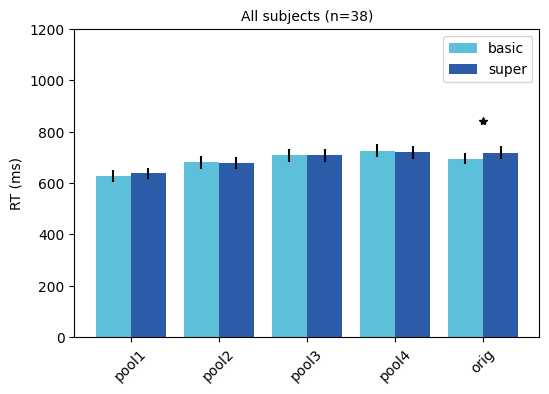

In [25]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = rt_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    if pvals[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+100
        plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

# plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='upper right')

plt.ylabel('RT (ms)')

plt.ylim([0, 1200])

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### pairwise comparisons across image types

In [32]:

pairs_test = list(itertools.combinations(np.arange(5),2))
n_pairs = len(pairs_test)
pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]

tvals = np.zeros((n_pairs))
pvals = np.zeros((n_pairs))

df = pd.DataFrame(index=pair_names)


# averaging across basic/super conds here
vals = np.mean(rt_by_condition, axis=1)

for pi, pair in enumerate(pairs_test):

    vals1 = vals[:,pair[0]]
    vals2 = vals[:,pair[1]]

    p, t = stats_utils.paired_ttest_nonpar(vals1, vals2)

    tvals[pi] = t
    pvals[pi] = p

df['t'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr


df   

,t,p
pool1 vs pool2,-10.0289,0.000000
pool1 vs pool3,-10.2817,0.000000
pool1 vs pool4,-10.3908,0.000000
pool1 vs orig,-6.9227,0.000000
pool2 vs pool3,-7.0772,0.000000
pool2 vs pool4,-7.1837,0.000000
pool2 vs orig,-2.9730,0.010000
pool3 vs pool4,-3.7482,0.000000
pool3 vs orig,0.1531,0.878000
pool4 vs orig,2.2761,0.033333


#### RTs: separate out the two image sets

In [28]:
for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = rt_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

    print(aov_table)


Image set 1:
(19, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              3.217396     1.0    18.0  8.967680e-02
image_type       29.716363     4.0    72.0  1.340814e-14
cond:image_type   6.620543     4.0    72.0  1.354216e-04

Image set 2:
(19, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              0.342259     1.0    18.0  5.657904e-01
image_type       18.873891     4.0    72.0  1.192131e-10
cond:image_type   1.514706     4.0    72.0  2.069694e-01


In [29]:
tvals = np.zeros((2,5))
pvals = np.zeros((2,5))

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = rt_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    for ii in range(n_image_types):
        
        p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])
        
        tvals[cbi, ii] = t
        pvals[cbi, ii] = p
        
# fdr correcting all the values together
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cbi, cb in enumerate([1,2]):
    
    df['Set %d: t'%cb] = tvals[cbi,:].round(4)
    df['Set %d: p'%cb] = pvals_fdr[cbi,:]

df


Image set 1:
(19, 2, 5)

Image set 2:
(19, 2, 5)


,Set 1: t,Set 1: p,Set 2: t,Set 2: p
pool1,-2.0015,0.240000,-1.3089,0.566667
pool2,0.8170,0.566667,0.0209,0.940000
pool3,-0.6517,0.566667,0.7580,0.566667
pool4,1.0249,0.566667,0.8152,0.566667
orig,-4.0604,0.000000,-1.2323,0.566667


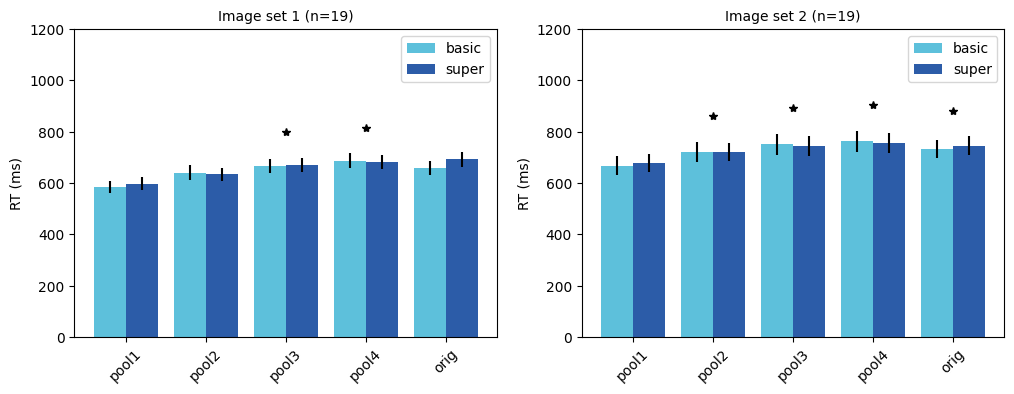

In [36]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(12,4))
    
for cbi, cb in enumerate([1,2]):

    ax = plt.subplot(1,2,cb)
    
    vals = rt_by_condition[subject_cb==cbi,:,:]
    
    n_subs_plot = vals.shape[0]
        
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
    
    lh = []
    
    for ii in range(n_image_types):
        
        for cc, cue in enumerate(cue_level_names):
        
            h = plt.bar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                            color = cue_level_colors[cc,:], width=barwidth)
            
            plt.errorbar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                             semvals[cc,ii], \
                            color = 'k',
                            linestyle='none')
        
            lh.append(h)
    
        if pvals[cbi, ii]<0.01:
            height = np.max(meanvals[:,ii]+semvals[:,ii])+100
            plt.plot(ii, height, '*', color='k')
    
        
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)
    
        
        
    
    # plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')
    
    ax.legend(lh, cue_level_names, loc='upper right')
    
    plt.ylabel('RT (ms)')
    
    plt.ylim([0, 1200])
    
    plt.title('Image set %d (n=%d)'%(cb, n_subs_plot))

#### pairwise comparisons across image types

In [31]:

for cbi, cb in enumerate([1,2]):
        
    pairs_test = list(itertools.combinations(np.arange(5),2))
    n_pairs = len(pairs_test)
    pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]
    
    tvals = np.zeros((n_pairs))
    pvals = np.zeros((n_pairs))
    
    df = pd.DataFrame(index=pair_names)
    
    
    # averaging across basic/super conds here
    vals = np.mean(rt_by_condition[subject_cb==cbi,:,:], axis=1)

    print(vals.shape)
    for pi, pair in enumerate(pairs_test):
    
        vals1 = vals[:,pair[0]]
        vals2 = vals[:,pair[1]]
    
        p, t = stats_utils.paired_ttest_nonpar(vals1, vals2)
    
        tvals[pi] = t
        pvals[pi] = p
    
    df['t'] = tvals.round(4)
    
    _, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
    df['p'] = pvals_fdr
    
    print('image set %d'%cb)
    print(df)   

(19, 5)
image set 1
                     t      p
pool1 vs pool2 -7.3341  0.000
pool1 vs pool3 -7.5617  0.000
pool1 vs pool4 -7.7940  0.000
pool1 vs orig  -5.9465  0.000
pool2 vs pool3 -4.7590  0.000
pool2 vs pool4 -5.1586  0.000
pool2 vs orig  -2.9899  0.004
pool3 vs pool4 -3.2599  0.000
pool3 vs orig  -0.7129  0.452
pool4 vs orig   1.1196  0.312
(19, 5)
image set 2
                     t      p
pool1 vs pool2 -6.7293  0.000
pool1 vs pool3 -6.8217  0.000
pool1 vs pool4 -6.7719  0.000
pool1 vs orig  -3.9783  0.000
pool2 vs pool3 -5.2974  0.000
pool2 vs pool4 -4.9431  0.000
pool2 vs orig  -1.2682  0.206
pool3 vs pool4 -2.0907  0.046
pool3 vs orig   0.7222  0.490
pool4 vs orig   1.9971  0.072
